In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from preprocessing import preprocesamiento_basico
from graficos_modelos import mostrar_reporte_clasificacion, graficar_auc_roc,graficar_matriz_confusion
from funciones_auxiliares import traer_datasets, traer_dataset_prediccion_final, separar_dataset, encontrar_hiperparametros_RGSCV, mapear_target_binario

# Random Forest

### Obtención de los datos y preprocesamiento

In [2]:
df, df_sin_target, solo_target = traer_datasets()

X_train, X_test, y_train, y_test = separar_dataset(df_sin_target, solo_target)

X_train.is_copy=False
X_test.is_copy=False
y_train.is_copy=False
y_test.is_copy=False

y_train.set_index('id', inplace=True)
y_train = y_train.sort_values(by=['id'], ascending=True).copy()

y_test.set_index('id', inplace=True)
y_test = y_test.sort_values(by=['id'], ascending=True).copy()


Aplicamos metodo de feature engineering general

In [3]:
dataframes_procesados = preprocesamiento_basico([X_train, X_test])
X_train = dataframes_procesados[0]
X_test = dataframes_procesados[1]

### Búsqueda de Hiperparámetros

Buscamos hiperparámetros con RandomGridSearch, pues GridSearch iterativamente es bastante lento. Para RandomForest, estos hiperparámetros serán:
* criterion: La función para medir la calidad de una división.
* n_estimators: La cantidad de árboles en el 

In [4]:
params = {'criterion': ['gini','entropy'], 'n_estimators':[100,300,500],'max_depth': np.arange(3,12)}
hiperparametros = encontrar_hiperparametros_RGSCV(RandomForestClassifier(), params=params, x_np=X_train.to_numpy(), y_np=y_train.to_numpy().ravel())

C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [5]:
criterio_elegido = hiperparametros['criterion']
cantidad_estimadores_elegida = hiperparametros['n_estimators']
profundidad_elegida = hiperparametros['max_depth']
print(f'Mejor criterio: {criterio_elegido}')
print(f'Mejor cantidad de estimadores: {cantidad_estimadores_elegida}')
print(f'Mejor profundidad_maxima: {profundidad_elegida}')

Mejor criterio: entropy
Mejor cantidad de estimadores: 500
Mejor profundidad_maxima: 11


### Entrenando el Modelo con CrossValidation

Procedemos a testear con kfolds, stratificados pues nuestro dataset es desbalanceado. Además, usamos los hiperparámetros encontrados previamente.

In [6]:
kf = StratifiedKFold(n_splits=5)
for fold_idx, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    bosque_clasificacion = RandomForestClassifier(max_depth=profundidad_elegida, n_estimators=cantidad_estimadores_elegida, criterion=criterio_elegido)
    bosque_clasificacion.fit(X_train.iloc[train_index], y_train.iloc[train_index].values.ravel())
    print ('Reporte para el FOLD ' + str(fold_idx))
    print(classification_report(y_train.iloc[test_index], bosque_clasificacion.predict(X_train.iloc[test_index]), target_names=['No llueven hamburguesas al dia siguiente', 'Llueven hamburguesas al dia siguiente']))
    

Reporte para el FOLD 0
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.86      0.96      0.91     15891
   Llueven hamburguesas al dia siguiente       0.77      0.44      0.56      4581

                                accuracy                           0.85     20472
                               macro avg       0.81      0.70      0.73     20472
                            weighted avg       0.84      0.85      0.83     20472

Reporte para el FOLD 1
                                          precision    recall  f1-score   support

No llueven hamburguesas al dia siguiente       0.87      0.92      0.90     15891
   Llueven hamburguesas al dia siguiente       0.66      0.52      0.59      4580

                                accuracy                           0.83     20471
                               macro avg       0.77      0.72      0.74     20471
                            weighted avg       

### Predicción del modelo sobre holdout

Una vez entrenado y validado el modelo con CrossValidation, viendo que las métricas resultantes fueron razonables y no dan indicio de overfit o mala división del dataset, pasaremos a probar el modelo en la partición Holdout. Para esto usaremos los mejores hiperparámetros hallados previamente en Training.

In [7]:
bosque_holdout = RandomForestClassifier(max_depth=profundidad_elegida, n_estimators=cantidad_estimadores_elegida, criterion=criterio_elegido)
bosque_holdout.fit(X_train.to_numpy(), y_train.to_numpy())

<ipython-input-7-be712caa8412>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bosque_holdout.fit(X_train.to_numpy(), y_train.to_numpy())


RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=500)

In [8]:
mapeo_binario_v = np.vectorize(mapear_target_binario)
y_pred = bosque_holdout.predict(X_test.to_numpy())
y_pred_binario = mapeo_binario_v(y_pred)
y_pred_proba = bosque_holdout.predict_proba(X_test.to_numpy())[:, 1]
y_test_binario = y_test['llovieron_hamburguesas_al_dia_siguiente'].map({'si': 1, 'no': 0}).to_numpy()
print(classification_report(y_test['llovieron_hamburguesas_al_dia_siguiente'].to_numpy(), y_pred))

              precision    recall  f1-score   support

          no       0.86      0.96      0.91      8828
          si       0.77      0.47      0.58      2545

    accuracy                           0.85     11373
   macro avg       0.81      0.72      0.75     11373
weighted avg       0.84      0.85      0.84     11373



### Curva AUC ROC


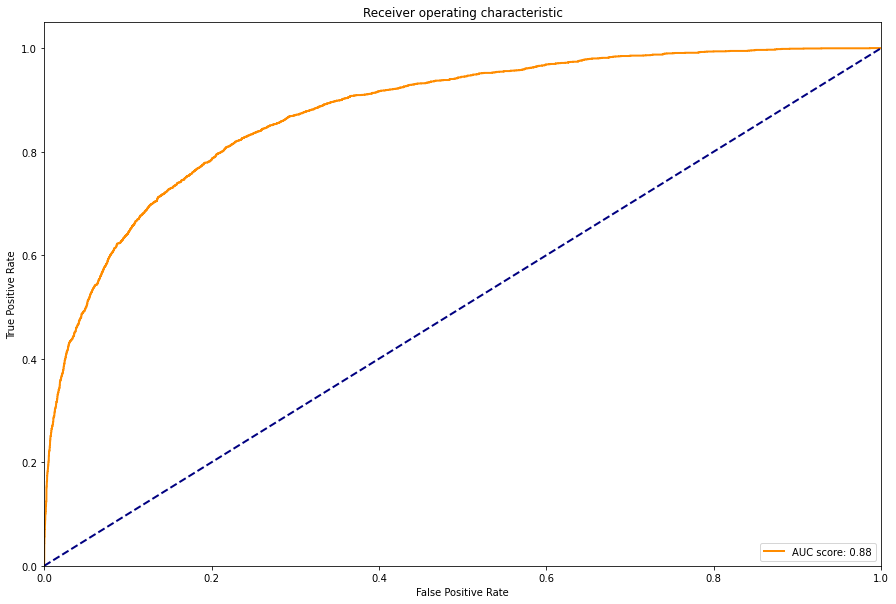

AUC-ROC para este modelo es: 0.8775461716292954


In [9]:
graficar_auc_roc(y_test_binario, y_pred_proba)

### Matriz de confusion

C:\Users\Guillermo\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


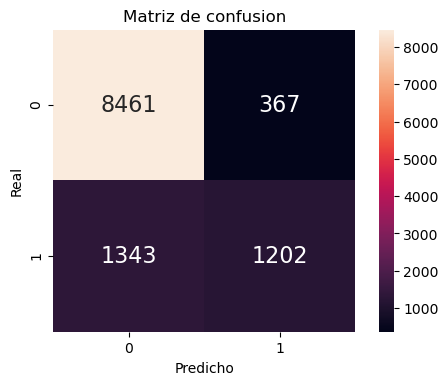

In [10]:
graficar_matriz_confusion(y_test_binario, y_pred_binario)

## Predicción con el dataset nuevo
A continuación, realizamos la predicción con el RandomForest sobre el dataset de predicciones nuevo, y la escribimos al archivo 'RandomForest.csv'

In [11]:
from funciones_auxiliares import exportar_prediccion_final

df_prediccion_final = traer_dataset_prediccion_final()
ids = df_prediccion_final['id'].to_numpy()

df_prediccion_final = preprocesamiento_basico([df_prediccion_final])[0]
predicciones = bosque_holdout.predict(df_prediccion_final.to_numpy())

exportar_prediccion_final(ids, predicciones, 'RandomForest')